In [ ]:
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from static import QuadcopterForceMoments
from vlm import VLM
from vpm_cuda import VPM
from wind import WindField
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import copy
import pyvista as pv
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------_#
wake_states = []  # List to store states at each time step

# Initialize geometry and mesh
# propeller_geometry = PropellerGeometry(
#     airfoil_distribution_file='DJI9443_airfoils.csv',
#     chorddist_file='DJI9443_chorddist.csv',
#     pitchdist_file='DJI9443_pitchdist.csv',
#     sweepdist_file='DJI9443_sweepdist.csv',
#     heightdist_file='DJI9443_heightdist.csv',
#     R_tip=0.11938,
#     R_hub=0.00624,
#     num_blades=2
# )

propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='NASA_UAM_quadrotor.csv',
    chorddist_file='NASA_UAM_quadrotor_chorddist.csv',
    pitchdist_file='NASA_UAM_quadrotor_pitchdist.csv',
    sweepdist_file='NASA_UAM_quadrotor_sweepdist.csv',
    R_tip=2.809,
    R_hub=0.3372,
    num_blades=3
)


propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=0.175, com=(0, 0, 0))
print('Propeller Loaded Succesfully')

quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()
print('Mesh Generated Succesfully')

# Initialize SixDOF dynamics
mass = 0.68  # kg
inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]

])  # Simple diagonal inertia matrix for example

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates


# Initialize the UVLM solver
uvlm_solver = VLM(quad_propeller_mesh)
# uvlm_solver.initialize_wake_system(quad_propeller_mesh)
# vpm_instance = VPM()
# vpm_instance.initialize_vpm_system()

wake_states = []

dynamics = SixDOFDynamics(
    mass=mass,
    inertia_matrix=inertia_matrix,
    initial_position=np.zeros(3),
    initial_velocity_body=np.zeros(3),
    initial_angles=np.zeros(3),
    initial_angular_rates=np.zeros(3)
)

thrust_history = []
wake_history = []
time_points = []
normalized_forces = []
rho = 1.071778   

mesh = pv.read(r"bp_50percent_75.vtk") 
wind_field = WindField(mesh)


target_rpm = 565
n_revs = 1
n_steps_rev = 36
n_steps = n_revs * n_steps_rev
dt = 2*np.pi / (target_rpm * n_steps_rev)

probe_steps = 1


x_positions = np.linspace(500, 150, probe_steps) 
x_positions = [325]
y_positions = [135]  # Three different y-positions to test
z_pos = 50  # Constant z position

moment_history = {y_pos: {
    'x_positions': [],
    'moments': {
        'Mx': [],
        'My': [],
        'Mz': []
    }
} for y_pos in y_positions}

for y_pos in y_positions:
    print(f"Testing y-position: {y_pos}")
    for x_pos  in x_positions:
        com_position = np.array([x_pos, y_pos, z_pos])

        print("Probe step:", x_pos)

        for time_step in range(1, n_steps):

            print("Step per revolution:", time_step)
            
            target_rpm = 565
            slow_start = 40
            # rpm = (min(time_step,slow_start)) / slow_start * target_rpm 
            rpm = target_rpm
            omega_dict = {  # Motor speed initialization
                'Propeller_1': np.array([0, 0, rpm]),
                'Propeller_2': np.array([0, 0, -rpm]),
                'Propeller_3': np.array([0, 0, -rpm]),
                'Propeller_4': np.array([0, 0, rpm])
            }

            # Step 1: Calculate forces and moments using UVLM
            forces_and_moments = uvlm_solver.calculate_total_forces_and_moments(
                propeller_mesh=quad_propeller_mesh,
                dt=dt,
                rho=rho,
                time_step=time_step,
                body_velocity=dynamics.velocity_body, 
                omega=omega_dict,
                wind_field=wind_field,
                com_position=com_position,
                roll=dynamics.angles[0],
                pitch=dynamics.angles[1],
                yaw=dynamics.angles[2],
                
            )
                    
            # # Add thrust data collection here
            # thrust_data = uvlm_solver.collect_thrust_data(
            # quad_propeller_mesh,
            # omega_dict,
            # time_step,
            # dt
            # )
            thrust = np.zeros(3)
            for prop_key in ['Propeller_1']:
                thrust += forces_and_moments[prop_key]['force'][2]

            print(forces_and_moments[prop_key]['force'][2])
            thrust_history.append({
            'time_step': time_step,
            'thrust': thrust
            })

            # total_moment = np.zeros(3)
            # for prop_key in ['Propeller_1', 'Propeller_2', 'Propeller_3', 'Propeller_4']:
            #     total_moment += forces_and_moments[prop_key]['moment']

            # # Store the position and moments
            # if x_pos not in moment_history[y_pos]['x_positions']:
            #     moment_history[y_pos]['x_positions'].append(x_pos)
            #     moment_history[y_pos]['moments']['Mx'].append(total_moment[0])
            #     moment_history[y_pos]['moments']['My'].append(total_moment[1])
            #     moment_history[y_pos]['moments']['Mz'].append(total_moment[2])

            # uvlm_solver.plot_detailed_gamma_distribution(quad_propeller_mesh)
            
            # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
            #                     "Propeller_1", azimuth=0, elevation=30)

            #  Step 2: Update mesh geometry for propeller rotation
            SixDOFDynamics.update_mesh_transformations(
                propeller_mesh=quad_propeller_mesh,
                dynamics=dynamics,
                dt=dt,
                omega_dict=omega_dict
            )
        
        # if x_pos not in moment_history['com_x']:
        #     moment_history['com_x'].append(x_pos)
                

            # Step 3: Update wake
            # uvlm_solver.update_wake(
            #     propeller_mesh=quad_propeller_mesh,
            #     time_step=time_step,
            #     dt=dt,
            #     body_velocity=dynamics.velocity_body,
            #     omega_dict=omega_dict,
            #     wind_field=wind_field,
            #     com_position=com_position,
            #     # vpm=vpm_instance
            # )
            
            
            # if time_step % 2 == 0:
            #     # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, "Propeller_1", azimuth=45, elevation=-10)
            #     fixed_radial_index = 3 
            #     uvlm_solver.plot_span_gamma_distribution(quad_propeller_mesh, fixed_radial_index)
            #     uvlm_solver.plot_chord_gamma_distribution(quad_propeller_mesh, fixed_radial_index)
            # fixed_radial_index = 3
            # uvlm_solver.plot_chord_gamma_distribution(quad_propeller_mesh, fixed_radial_index)
            # uvlm_solver.plot_detailed_gamma_distribution(quad_propeller_mesh)

            # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
            #                     "Propeller_1", azimuth=0, elevation=30)

        #     uvlm_solver.plot_blades_pressure_top_view(
        #     quad_propeller_mesh,
        #     propeller_key="Propeller_1",
        #     omega=omega_dict["Propeller_1"], 
        #     body_velocity=initial_body_velocity,   
        #     rho=rho
        # )

        # if thrust_history:  # Only if we have collected data
        #     uvlm_solver.plot_thrust_disk(thrust_history, n_steps_rev=n_steps_rev)

def plot_moments_combined(moment_history):
    """
    Create a plot showing moment components vs x-position for different y-positions
    with separate legends for moment types and y-positions.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    # Colors for each moment component
    colors = {
        'Mx': '#FB8861',  # Orange-red
        'My': '#F7D43B',  # Yellow
        'Mz': '#9C179E'   # Purple
    }
    
    # Line styles for different y-positions
    line_styles = {
        0: '-',    # solid
        1: '--',   # dashed
        2: ':',    # dotted
    }
    
    # Marker styles for different y-positions
    marker_styles = {
        0: 'o',    # circle
        1: 's',    # square
        2: '^',    # triangle
    }
    
    moment_lines = []  # Store lines for moment types legend
    position_lines = []  # Store lines for position legend
    labels = ['Rolling Moment', 'Pitching Moment', 'Yawing Moment']
    moment_keys = ['Mx', 'My', 'Mz']
    
    # First, create dummy lines for moment type legend
    for label, color in zip(labels, colors.values()):
        line = ax.plot([], [], color=color, label=label, linewidth=2.0)[0]
        moment_lines.append(line)
    
    # Then create dummy lines for position legend
    for y_idx, y_pos in enumerate(moment_history.keys()):
        line = ax.plot([], [], color='black', 
              linestyle=line_styles[y_idx],
              marker=marker_styles[y_idx],
              label=fr'$Y_{{\mathrm{{ECEF}}}}$ = {y_pos} m',  # Updated label
              markersize=8,
              markerfacecolor='white',
              markeredgewidth=2)[0]
        position_lines.append(line)
    
    # Now plot the actual data
    for y_idx, (y_pos, data) in enumerate(moment_history.items()):
        x_positions = np.array(data['x_positions'])
        
        for moment_key, color in zip(moment_keys, colors.values()):
            moment_values = np.array(data['moments'][moment_key])
            
            ax.plot(x_positions, moment_values,
                   color=color,
                   linestyle=line_styles[y_idx],
                   linewidth=2.0,
                   marker=marker_styles[y_idx],
                   markersize=8,
                   markevery=1,
                   markerfacecolor='white',
                   markeredgewidth=2,
                   zorder=3)
    
    # Customize axes
    ax.set_xlabel(r'$X_{ECEF}$ (m)', fontsize=20)
    ax.set_ylabel('Moment (N⋅m)', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    
    # Add two legends
    # First legend for moment types
    legend1 = ax.legend(handles=moment_lines,
                       bbox_to_anchor=(0.5, -0.15),
                       loc='upper center',
                       fontsize=16,
                       ncol=3,
                       framealpha=1.0,
                       )
    
    # Add the first legend manually
    ax.add_artist(legend1)
    
    # Second legend for y-positions
    legend2 = ax.legend(handles=position_lines,
                       bbox_to_anchor=(0.5, -0.25),
                       loc='upper center',
                       fontsize=16,
                       ncol=3,
                       framealpha=1.0,
                       )
    
    # Customize grid and spines
    ax.grid(True, linestyle='--', alpha=0.2, zorder=1)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.5)
    
    # Set background color
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Increased bottom margin for two legends
    
    # Save numerical data to CSV
    with open('moments_data_multi_y.csv', 'w') as f:
        # Write header
        header = 'y_position,x_position,Mx,My,Mz\n'
        f.write(header)
        
        # Write data for each y-position
        for y_pos, data in moment_history.items():
            for i, x_pos in enumerate(data['x_positions']):
                f.write(f'{y_pos},{x_pos},'
                       f'{data["moments"]["Mx"][i]},'
                       f'{data["moments"]["My"][i]},'
                       f'{data["moments"]["Mz"][i]}\n')
    
    plt.show()

# After your simulation loop completes, call the plotting function:
# plot_moments_combined(moment_history)
# uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, "Propeller_1", azimuth=0, elevation=1)

# uvlm_solver.plot_thrust_history(thrust_history)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import matplotlib.cm as cm

# Read the CSV file
df = pd.read_csv('rpm_wind_simulation_results.csv')

# Extract column names for clarity
columns = df.columns.tolist()
rpm_col = columns[0]    # First column - RPM
velco_col = columns[1]  # 6th column - Velco
qz_col = columns[12]    # 15th column - Qz
c_col = columns[2]      # Assuming "c" is in the 3rd column - adjust if needed

# Get data from the dataframe
x = df[rpm_col].values
y = df[velco_col].values
z = df[qz_col].values
c = df[c_col].values  # Getting the fourth variable "c"

# Determine the highest practical order for polynomial fitting
n_points = len(x)
max_practical_order = min(6, int(np.sqrt(n_points) / 2))  # Reduced due to more variables
print(f"Using polynomial of order {max_practical_order} based on {n_points} data points")

# Prepare data for polynomial fitting (now including "c" as a feature)
X = np.column_stack((x, y, c))

# Create a polynomial regression model
model = make_pipeline(
    PolynomialFeatures(degree=max_practical_order, include_bias=True),
    LinearRegression()
)
model.fit(X, z)

# Calculate R² score on the training data
z_pred = model.predict(X)
r2 = r2_score(z, z_pred)
print(f"R² Score: {r2:.4f}")

# Since we have 4 variables, we need to visualize in multiple ways
# Option 1: 3D plots with color representing the 4th dimension (c)

# Create a series of 3D surface plots at different fixed values of "c"
c_min, c_max = min(c), max(c)
c_values = np.linspace(c_min, c_max, 5)  # 5 different values of c to visualize

# Create a figure with subplots
fig = plt.figure(figsize=(20, 15))

# Calculate the polynomial coefficients for analysis and equation
poly_features = model.named_steps['polynomialfeatures']
feature_names = poly_features.get_feature_names_out([rpm_col, velco_col, c_col])
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_

# Save full model equation to a text file
equation = f"{qz_col} = {intercept:.6e}"
for name, coef in zip(feature_names, coefficients):
    if abs(coef) > 1e-8:  # Only include significant terms
        equation += f" + ({coef:.6e})*{name}"

# Print shortened equation (just first few terms)
print("Polynomial equation (truncated):")
terms = equation.split("+")
print("+".join(terms[:6]) + " + ...")
print(f"Full equation saved to 'polynomial_model_equation.txt' ({len(terms)} terms)")

# Save full equation to file
with open('polynomial_model_equation.txt', 'w') as f:
    f.write(equation)

# Create the 3D plots for different c values
for i, c_val in enumerate(c_values):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    
    # Create a mesh grid for visualization
    x_range = np.linspace(min(x), max(x), 30)
    y_range = np.linspace(min(y), max(y), 30)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    
    # Prepare data for prediction - same c value for all points
    c_mesh = np.full(X_mesh.shape, c_val)
    XYC_mesh = np.column_stack((X_mesh.flatten(), Y_mesh.flatten(), c_mesh.flatten()))
    
    # Predict Z values using the polynomial model
    Z_pred_mesh = model.predict(XYC_mesh).reshape(X_mesh.shape)
    
    # Create the surface plot for this c value
    surf = ax.plot_surface(X_mesh, Y_mesh, Z_pred_mesh, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # Find data points with c values close to this c_val to plot as markers
    c_threshold = (c_max - c_min) / 10  # Adjust threshold as needed
    mask = np.abs(c - c_val) < c_threshold
    if np.any(mask):
        scatter = ax.scatter(x[mask], y[mask], z[mask], c='red', s=30)
    
    # Set labels and title
    ax.set_xlabel(rpm_col, fontsize=10)
    ax.set_ylabel(velco_col, fontsize=10)
    ax.set_zlabel(qz_col, fontsize=10)
    ax.set_title(f'Polynomial Fit at {c_col}={c_val:.2f}', fontsize=12)
    
    # Add R² to each plot
    ax.text2D(0.05, 0.95, f'R² Score: {r2:.4f}', transform=ax.transAxes, fontsize=10)
    
    # Set viewing angle
    ax.view_init(elev=30, azim=45)

# Additional plot: Predicted vs Actual values
ax = fig.add_subplot(2, 3, 6)
scatter = ax.scatter(z, z_pred, c=c, cmap='coolwarm', alpha=0.7)
ax.plot([min(z), max(z)], [min(z), max(z)], 'k--')  # Diagonal line
ax.set_xlabel('Actual Qz', fontsize=12)
ax.set_ylabel('Predicted Qz', fontsize=12)
ax.set_title('Actual vs Predicted Values', fontsize=14)
ax.grid(True)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(c_col)

# Improve overall layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle(f'Polynomial Model (Order {max_practical_order}) of {rpm_col}, {velco_col}, {c_col} → {qz_col}', 
             fontsize=16, y=0.98)

# Show the plot
plt.show()

# Create a scatter plot to visualize how well each data point is predicted
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Calculate residuals
residuals = z - z_pred

# Create scatter plot with points colored by residual
scatter = ax2.scatter(z_pred, residuals, c=c, cmap='coolwarm', alpha=0.7, s=50)

# Add reference line at y=0
ax2.axhline(y=0, color='k', linestyle='--')

# Set labels and title
ax2.set_xlabel('Predicted Qz', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title('Residual Plot for 4-Variable Polynomial Model', fontsize=14)
ax2.grid(True)

# Add color bar for the fourth variable (c)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label(c_col)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Feature importance analysis
abs_coefficients = np.abs(coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Absolute Coefficient': abs_coefficients,
    'Normalized Importance': abs_coefficients / np.sum(abs_coefficients)
})
feature_importance = feature_importance.sort_values('Absolute Coefficient', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Plot feature importance (top 20 features)
plt.figure(figsize=(14, 8))
feature_importance.head(20).plot(kind='bar', x='Feature', y='Normalized Importance')
plt.title('Feature Importance in Polynomial Model')
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import matplotlib.cm as cm

# Read the CSV file
df = pd.read_csv('rpm_wind_simulation_results.csv')

# Print column names to verify
print("Column names in the CSV file:")
for i, col in enumerate(df.columns):
    print(f"Column {i} (Excel column {chr(65+i)}): {col}")

# Extract specific columns based on your clarification
rpm_col = df.columns[0]     # Column A - RPM
wind_z_col = df.columns[5]  # Column F - Wind Z (previously called Velco)
angle_col = df.columns[2]   # Column C - Angle
qz_col = df.columns[12]     # Column M - Qz (not column O as initially thought)

print(f"\nUsing these columns:")
print(f"RPM: {rpm_col} (Excel column A)")
print(f"Wind Z: {wind_z_col} (Excel column F)")
print(f"Angle: {angle_col} (Excel column C)")
print(f"Qz: {qz_col} (Excel column M)")

# Get data from the dataframe
rpm = df[rpm_col].values
wind_z = df[wind_z_col].values
angle = df[angle_col].values
qz = df[qz_col].values

# Print basic statistics about Qz
print(f"\nQz Statistics (Column M):")
print(f"  Range: [{min(qz):.2f}, {max(qz):.2f}]")
print(f"  Mean: {np.mean(qz):.2f}")
print(f"  Median: {np.median(qz):.2f}")
print(f"  Standard Deviation: {np.std(qz):.2f}")

# 1. Basic Histogram of Qz values
plt.figure(figsize=(12, 6))
plt.hist(qz, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {qz_col} Values (Excel Column M)', fontsize=14)
plt.xlabel(qz_col, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Scatter plot of Qz vs RPM
plt.figure(figsize=(12, 6))
scatter = plt.scatter(rpm, qz, c=wind_z, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label=wind_z_col)
plt.title(f'{qz_col} vs {rpm_col} (colored by {wind_z_col})', fontsize=14)
plt.xlabel(rpm_col, fontsize=12)
plt.ylabel(f'{qz_col} (Excel Column M)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Scatter plot of Qz vs Wind Z
plt.figure(figsize=(12, 6))
scatter = plt.scatter(wind_z, qz, c=rpm, cmap='plasma', alpha=0.7, s=50)
plt.colorbar(scatter, label=rpm_col)
plt.title(f'{qz_col} vs {wind_z_col} (colored by {rpm_col})', fontsize=14)
plt.xlabel(wind_z_col, fontsize=12)
plt.ylabel(f'{qz_col} (Excel Column M)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 3D Scatter plot of RPM, Wind Z, and Qz
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rpm, wind_z, qz, c=qz, cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel(rpm_col, fontsize=12)
ax.set_ylabel(wind_z_col, fontsize=12)
ax.set_zlabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax.set_title(f'3D Scatter Plot of {rpm_col}, {wind_z_col}, and {qz_col}', fontsize=14)
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label=qz_col)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

# 5. Heat map of Qz as a function of RPM and Wind Z
# Create a 2D grid from our data points
from scipy.interpolate import griddata

# Create grid for interpolation
grid_size = 100
rpm_grid = np.linspace(min(rpm), max(rpm), grid_size)
wind_z_grid = np.linspace(min(wind_z), max(wind_z), grid_size)
RPM_mesh, WIND_Z_mesh = np.meshgrid(rpm_grid, wind_z_grid)

# Interpolate Qz values onto the grid
points = np.column_stack((rpm, wind_z))
QZ_mesh = griddata(points, qz, (RPM_mesh, WIND_Z_mesh), method='cubic')

# Create heatmap
plt.figure(figsize=(14, 10))
heatmap = plt.pcolormesh(RPM_mesh, WIND_Z_mesh, QZ_mesh, cmap='inferno', shading='auto')
plt.colorbar(heatmap, label=f'{qz_col} (Excel Column M)')
plt.title(f'Heatmap of {qz_col} as a function of {rpm_col} and {wind_z_col}', fontsize=14)
plt.xlabel(rpm_col, fontsize=12)
plt.ylabel(wind_z_col, fontsize=12)

# Add contour lines to better visualize Qz levels
contour = plt.contour(RPM_mesh, WIND_Z_mesh, QZ_mesh, colors='white', alpha=0.5, linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%.1f')

plt.tight_layout()
plt.show()

# 6. Multiple slices of Qz vs RPM at different Wind Z values
plt.figure(figsize=(14, 8))

# Get unique Wind Z values (or create bins if there are too many)
if len(np.unique(wind_z)) > 5:
    # Create 5 bins of Wind Z values
    wind_z_bins = np.linspace(min(wind_z), max(wind_z), 6)
    wind_z_centers = (wind_z_bins[:-1] + wind_z_bins[1:]) / 2
    
    for i in range(5):
        # Get data points in this Wind Z bin
        mask = (wind_z >= wind_z_bins[i]) & (wind_z < wind_z_bins[i+1])
        if np.sum(mask) > 0:  # Only plot if we have data points
            plt.scatter(rpm[mask], qz[mask], label=f'{wind_z_col}: {wind_z_centers[i]:.2f}', alpha=0.7)
else:
    # If there are only a few unique Wind Z values, use them directly
    for v in np.unique(wind_z):
        mask = wind_z == v
        plt.scatter(rpm[mask], qz[mask], label=f'{wind_z_col}: {v:.2f}', alpha=0.7)

plt.title(f'{qz_col} vs {rpm_col} at different {wind_z_col} values', fontsize=14)
plt.xlabel(rpm_col, fontsize=12)
plt.ylabel(f'{qz_col} (Excel Column M)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Surface plot of Qz with polynomial fit
# Create polynomial model for visualization
model = make_pipeline(
    PolynomialFeatures(degree=4),  # Use a moderate degree for visualization
    LinearRegression()
)

# Fit model to RPM and Wind Z data to predict Qz
X = np.column_stack((rpm, wind_z))
model.fit(X, qz)

# Create a mesh grid for visualization
x_range = np.linspace(min(rpm), max(rpm), 50)
y_range = np.linspace(min(wind_z), max(wind_z), 50)
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
XY_mesh = np.column_stack((X_mesh.flatten(), Y_mesh.flatten()))

# Predict Qz values using the polynomial model
Z_pred_mesh = model.predict(XY_mesh).reshape(X_mesh.shape)

# Create the surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_mesh, Y_mesh, Z_pred_mesh, cmap='viridis', alpha=0.8, edgecolor='none')

# Plot the original data points
scatter = ax.scatter(rpm, wind_z, qz, c='red', s=30, alpha=0.5)

# Set labels and title
ax.set_xlabel(rpm_col, fontsize=12)
ax.set_ylabel(wind_z_col, fontsize=12)
ax.set_zlabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax.set_title(f'Polynomial Surface Fit of {qz_col} based on {rpm_col} and {wind_z_col}', fontsize=14)

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label(qz_col)

# Set viewing angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# 8. Qz contour lines with RPM and Wind Z
plt.figure(figsize=(14, 10))
contour = plt.contourf(RPM_mesh, WIND_Z_mesh, QZ_mesh, levels=20, cmap='viridis')
plt.colorbar(contour, label=f'{qz_col} (Excel Column M)')
plt.scatter(rpm, wind_z, c=qz, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
plt.title(f'Contour Plot of {qz_col} with {rpm_col} and {wind_z_col}', fontsize=14)
plt.xlabel(rpm_col, fontsize=12)
plt.ylabel(wind_z_col, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. 3D Surface plot focused on Qz
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
surf = ax.plot_surface(RPM_mesh, WIND_Z_mesh, QZ_mesh, cmap='viridis', 
                      edgecolor='none', alpha=0.8, antialiased=True)

# Plot the original data points
scatter = ax.scatter(rpm, wind_z, qz, c='red', s=30, alpha=0.5)

ax.set_xlabel(rpm_col, fontsize=12)
ax.set_ylabel(wind_z_col, fontsize=12)
ax.set_zlabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax.set_title(f'Interpolated Surface Plot of {qz_col}', fontsize=14)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label(qz_col)

# Set viewing angle for best Qz visualization
ax.view_init(elev=40, azim=30)

plt.tight_layout()
plt.show()

# 10. Create parameter sweep plots to see Qz's relationship with each variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Group data by RPM ranges and show mean Qz with error bars
rpm_bins = np.linspace(min(rpm), max(rpm), 10)
rpm_centers = (rpm_bins[:-1] + rpm_bins[1:]) / 2
qz_means = []
qz_stds = []

for i in range(len(rpm_bins)-1):
    mask = (rpm >= rpm_bins[i]) & (rpm < rpm_bins[i+1])
    if np.sum(mask) > 0:
        qz_means.append(np.mean(qz[mask]))
        qz_stds.append(np.std(qz[mask]))
    else:
        qz_means.append(np.nan)
        qz_stds.append(np.nan)

ax1.errorbar(rpm_centers, qz_means, yerr=qz_stds, fmt='o-', capsize=5)
ax1.set_title(f'Mean {qz_col} vs {rpm_col}', fontsize=12)
ax1.set_xlabel(rpm_col, fontsize=10)
ax1.set_ylabel(f'Mean {qz_col} (Excel Column M)', fontsize=10)
ax1.grid(True, alpha=0.3)

# Group data by Wind Z ranges and show mean Qz with error bars
wind_z_bins = np.linspace(min(wind_z), max(wind_z), 10)
wind_z_centers = (wind_z_bins[:-1] + wind_z_bins[1:]) / 2
qz_means = []
qz_stds = []

for i in range(len(wind_z_bins)-1):
    mask = (wind_z >= wind_z_bins[i]) & (wind_z < wind_z_bins[i+1])
    if np.sum(mask) > 0:
        qz_means.append(np.mean(qz[mask]))
        qz_stds.append(np.std(qz[mask]))
    else:
        qz_means.append(np.nan)
        qz_stds.append(np.nan)

ax2.errorbar(wind_z_centers, qz_means, yerr=qz_stds, fmt='o-', capsize=5)
ax2.set_title(f'Mean {qz_col} vs {wind_z_col}', fontsize=12)
ax2.set_xlabel(wind_z_col, fontsize=10)
ax2.set_ylabel(f'Mean {qz_col} (Excel Column M)', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11. Plot 3D data with angle color coding
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with angle color-coding
scatter = ax.scatter(rpm, wind_z, qz, c=angle, cmap='coolwarm', s=40, alpha=0.7)

ax.set_xlabel(rpm_col, fontsize=12)
ax.set_ylabel(wind_z_col, fontsize=12)
ax.set_zlabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax.set_title(f'3D Scatter Plot with {angle_col} Color Coding', fontsize=14)

# Add color bar for angle
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label(angle_col)

# Set viewing angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# 12. Visualize Qz vs Angle relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Qz vs Angle colored by RPM
scatter1 = ax1.scatter(angle, qz, c=rpm, cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel(angle_col, fontsize=12)
ax1.set_ylabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax1.set_title(f'{qz_col} vs {angle_col} (colored by {rpm_col})', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label=rpm_col)

# Qz vs Angle colored by Wind Z
scatter2 = ax2.scatter(angle, qz, c=wind_z, cmap='plasma', alpha=0.7, s=50)
ax2.set_xlabel(angle_col, fontsize=12)
ax2.set_ylabel(f'{qz_col} (Excel Column M)', fontsize=12)
ax2.set_title(f'{qz_col} vs {angle_col} (colored by {wind_z_col})', fontsize=14)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label=wind_z_col)

plt.tight_layout()
plt.show()

# 13. Now add a 3D polynomial model that includes all three variables
print("\nFitting a 3D polynomial model including RPM, Wind Z, and Angle to predict Qz...")

# Create model for all three variables
full_model = make_pipeline(
    PolynomialFeatures(degree=3),  # Lower degree for 3 variables 
    LinearRegression()
)

# Fit model using all three variables
X_full = np.column_stack((rpm, wind_z, angle))
full_model.fit(X_full, qz)

# Calculate and print R² score
qz_pred_full = full_model.predict(X_full)
r2_full = r2_score(qz, qz_pred_full)
print(f"R² Score with all three variables: {r2_full:.4f}")

# Create a 3D visualization showing Qz predictions at different angle values
angle_values = np.percentile(angle, [25, 50, 75])  # 25th, 50th, and 75th percentiles of angle

fig = plt.figure(figsize=(18, 6))
fig.suptitle(f'Polynomial Model Predictions at Different {angle_col} Values', fontsize=16)

for i, angle_val in enumerate(angle_values):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Create a mesh grid for visualization 
    x_range = np.linspace(min(rpm), max(rpm), 30)
    y_range = np.linspace(min(wind_z), max(wind_z), 30)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    
    # Create points with the fixed angle value
    angle_mesh = np.full(X_mesh.shape, angle_val)
    XYA_mesh = np.column_stack((X_mesh.flatten(), Y_mesh.flatten(), angle_mesh.flatten()))
    
    # Predict Qz values
    Z_pred_mesh = full_model.predict(XYA_mesh).reshape(X_mesh.shape)
    
    # Create the surface plot
    surf = ax.plot_surface(X_mesh, Y_mesh, Z_pred_mesh, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # Find data points with angle values close to this angle_val to plot as markers
    angle_threshold = (max(angle) - min(angle)) / 10
    mask = np.abs(angle - angle_val) < angle_threshold
    if np.sum(mask) > 0:
        scatter = ax.scatter(rpm[mask], wind_z[mask], qz[mask], c='red', s=30, alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel(rpm_col, fontsize=10)
    ax.set_ylabel(wind_z_col, fontsize=10)
    ax.set_zlabel(qz_col, fontsize=10)
    ax.set_title(f'{angle_col} = {angle_val:.2f}°', fontsize=12)
    
    # Set consistent view angle
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# 14. Create a function to solve for Wind Z given RPM, Angle, and desired Qz
from scipy.optimize import minimize

def find_wind_z(rpm_value, angle_value, qz_target, initial_guess=None):
    """Find the Wind Z value that produces the target Qz for given RPM and Angle."""
    if initial_guess is None:
        initial_guess = np.mean(wind_z)
    
    def objective(v):
        wind_z_val = v[0]
        X_test = np.array([[rpm_value, wind_z_val, angle_value]])
        qz_predicted = full_model.predict(X_test)[0]
        return (qz_predicted - qz_target)**2
    
    result = minimize(objective, np.array([initial_guess]), method='L-BFGS-B', 
                     bounds=[(min(wind_z), max(wind_z))])
    
    return result.x[0], result.fun

# Test the inverse solver with example values
print("\nTesting the inverse solver to find Wind Z given RPM, Angle, and Qz...")
test_rpm = np.percentile(rpm, 50)  # median RPM
test_angle = np.percentile(angle, 50)  # median angle
test_qz = np.percentile(qz, 50)  # median Qz

wind_z_found, error = find_wind_z(test_rpm, test_angle, test_qz)
print(f"For RPM={test_rpm:.1f}, Angle={test_angle:.2f}°, Target Qz={test_qz:.2f}:")
print(f"  Predicted Wind Z: {wind_z_found:.4f}")

# Verify the solution
X_verify = np.array([[test_rpm, wind_z_found, test_angle]])
qz_verify = full_model.predict(X_verify)[0]
print(f"  Verification: Using the found Wind Z gives Qz = {qz_verify:.2f}")
print(f"  Error: {((qz_verify - test_qz)/test_qz*100):.2f}%")

# 15. Create a user-friendly function for the inverse problem
def solve_for_wind_z(rpm_value, angle_value, qz_value):
    """User-friendly function to find Wind Z given RPM, Angle, and Qz."""
    try:
        # Check if inputs are within the range of training data
        if rpm_value < min(rpm) or rpm_value > max(rpm):
            print(f"Warning: RPM value {rpm_value} is outside the training data range [{min(rpm):.1f}, {max(rpm):.1f}]")
        if angle_value < min(angle) or angle_value > max(angle):
            print(f"Warning: Angle value {angle_value} is outside the training data range [{min(angle):.1f}, {max(angle):.1f}]")
        if qz_value < min(qz) or qz_value > max(qz):
            print(f"Warning: Qz value {qz_value} is outside the training data range [{min(qz):.1f}, {max(qz):.1f}]")
        
        # Find Wind Z using the full model
        wind_z_val, error = find_wind_z(rpm_value, angle_value, qz_value)
        
        # Verify the solution
        X_verify = np.array([[rpm_value, wind_z_val, angle_value]])
        qz_verify = full_model.predict(X_verify)[0]
        
        error_pct = (qz_verify - qz_value)/qz_value*100 if qz_value != 0 else (qz_verify - qz_value)
        
        print(f"Solution for RPM={rpm_value:.1f}, Angle={angle_value:.2f}°, Qz={qz_value:.2f}:")
        print(f"  Wind Z = {wind_z_val:.4f}")
        print(f"  Verification: Predicted Qz = {qz_verify:.2f} (Error: {error_pct:.2f}%)")
        
        if abs(error_pct) > 5:
            print("  Warning: Error exceeds 5% - solution may be outside model's reliable range")
        
        return wind_z_val
    
    except Exception as e:
        print(f"Error solving for Wind Z: {e}")
        return None

# Print final instructions
print("""
=== HOW TO USE THE INVERSE SOLVER ===

To find Wind Z for specific RPM, Angle, and Qz values:
    wind_z = solve_for_wind_z(rpm_value, angle_value, qz_value)

Example:
    wind_z = solve_for_wind_z(1500, 10.0, 100)
    
This will return the Wind Z value that, when combined with the given RPM and Angle,
produces the target Qz according to the polynomial model.
""")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print("Loading and analyzing data...")

# Read the CSV file (replace with your Excel file if needed)
df = pd.read_csv('rpm_wind_simulation_results.csv')

# Use the correct column names from the headers you provided
rad_s_col = 'RPM'          # Column A - Angular velocity in rad/s
wind_mag_col = 'WindMagnitude'  # Column B - Wind magnitude
angle_col = 'AngleDegrees'      # Column C - Angle in degrees
wind_z_col = 'WindZ'         # Column F - Wind Z component (Velco)
qz_col = 'Qz'                # Column M - Torque Z component

# Extract the data
rad_s = df[rad_s_col].values
wind_mag = df[wind_mag_col].values
angle_deg = df[angle_col].values
wind_z = df[wind_z_col].values
qz = df[qz_col].values

# Print basic statistics about the data
print("\nData Statistics:")
print(f"Number of data points: {len(rad_s)}")
print(f"{rad_s_col} range: [{min(rad_s):.2f}, {max(rad_s):.2f}] rad/s")
print(f"{wind_mag_col} range: [{min(wind_mag):.2f}, {max(wind_mag):.2f}]")
print(f"{angle_col} range: [{min(angle_deg):.2f}, {max(angle_deg):.2f}] degrees")
print(f"{wind_z_col} range: [{min(wind_z):.2f}, {max(wind_z):.2f}]")
print(f"{qz_col} range: [{min(qz):.2f}, {max(qz):.2f}]")

# Verify the relationship WindZ = WindMagnit * sin(AngleDegr)
angle_rad = np.radians(angle_deg)
calculated_wind_z = wind_mag * np.sin(angle_rad)
wind_z_error = np.mean(np.abs((calculated_wind_z - wind_z) / wind_z)) * 100

print(f"\nVerifying WindZ = WindMagnit * sin(AngleDegr): Average error = {wind_z_error:.2f}%")

# Build model: Qz = f(Rad/s, WindMagnit, AngleDegr)
print("\nBuilding polynomial model with normalization...")

# Determine appropriate polynomial order based on data size
n_points = len(rad_s)
max_order = min(6, int(np.sqrt(n_points) / 2))
print(f"Using polynomial order: {max_order}")

# Create a normalized polynomial model
# 1. StandardScaler to normalize inputs
# 2. PolynomialFeatures to create interaction terms
# 3. Another StandardScaler for the polynomial features
# 4. LinearRegression to fit the model
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=max_order, include_bias=False),
    StandardScaler(),
    LinearRegression()
)

# Prepare input features and fit the model
X = np.column_stack((rad_s, wind_mag, angle_deg))
model.fit(X, qz)

# Calculate R² score on the training data
qz_pred = model.predict(X)
r2 = r2_score(qz, qz_pred)
print(f"Model R² Score: {r2:.4f}")

# Calculate RMSE
rmse = np.sqrt(np.mean((qz - qz_pred)**2))
print(f"Model RMSE: {rmse:.4f}")

# Define the inverse solver function
def solve_for_wind_magnitude_and_angle(rad_s_value, qz_value, max_attempts=5):
    """
    Find WindMagnit and AngleDegr values that produce the target Qz for a given Rad/s.
    
    Args:
        rad_s_value: The Rad/s value
        qz_value: The target Qz value
        max_attempts: Number of optimization attempts with different starting points
        
    Returns:
        Tuple of (WindMagnit, AngleDegr, WindZ, error_percent)
    """
    wind_mag_min, wind_mag_max = min(wind_mag), max(wind_mag)
    angle_min, angle_max = min(angle_deg), max(angle_deg)
    
    # Define the objective function to minimize
    def objective(params):
        wind_mag_val, angle_val = params
        
        # Create input array
        X_test = np.array([[rad_s_value, wind_mag_val, angle_val]])
        
        # Predict Qz using the model
        qz_predicted = model.predict(X_test)[0]
        
        # Return the squared difference
        return (qz_predicted - qz_value)**2
    
    # Try multiple starting points to avoid local minima
    best_result = None
    best_error = float('inf')
    
    # Create a grid of starting points
    wind_mag_starts = np.linspace(wind_mag_min, wind_mag_max, max_attempts)
    angle_starts = np.linspace(angle_min, angle_max, max_attempts)
    
    for i in range(max_attempts):
        # Use different starting points
        start_wind_mag = wind_mag_starts[i % max_attempts]
        start_angle = angle_starts[i % max_attempts]
        
        try:
            # Run the optimization
            result = minimize(
                objective, 
                [start_wind_mag, start_angle],
                method='L-BFGS-B',
                bounds=[(wind_mag_min, wind_mag_max), (angle_min, angle_max)]
            )
            
            if result.fun < best_error:
                best_result = result
                best_error = result.fun
        except:
            continue
    
    if best_result is None:
        raise ValueError("Optimization failed for all starting points")
    
    # Extract the optimal values
    wind_mag_optimal, angle_optimal = best_result.x
    
    # Calculate WindZ = WindMagnit * sin(AngleDegr)
    wind_z_optimal = wind_mag_optimal * np.sin(np.radians(angle_optimal))
    
    # Verify the solution
    X_verify = np.array([[rad_s_value, wind_mag_optimal, angle_optimal]])
    qz_verify = model.predict(X_verify)[0]
    
    # Calculate error percentage
    error_pct = abs((qz_verify - qz_value) / qz_value * 100) if qz_value != 0 else abs(qz_verify - qz_value)
    
    return wind_mag_optimal, angle_optimal, wind_z_optimal, error_pct

# Test the inverse solver with sample points from the dataset
print("\nTesting the inverse solver with sample data points...")

# Sample a few points from the dataset for testing
np.random.seed(42)
test_indices = np.random.choice(len(rad_s), size=5, replace=False)

for i, idx in enumerate(test_indices):
    # Get original values
    test_rad_s = rad_s[idx]
    test_qz = qz[idx]
    actual_wind_mag = wind_mag[idx]
    actual_angle = angle_deg[idx]
    actual_wind_z = wind_z[idx]
    
    # Predict values
    pred_wind_mag, pred_angle, pred_wind_z, error = solve_for_wind_magnitude_and_angle(test_rad_s, test_qz)
    
    # Calculate errors
    wind_mag_error = abs((pred_wind_mag - actual_wind_mag) / actual_wind_mag * 100)
    angle_error = abs((pred_angle - actual_angle) / actual_angle * 100) if actual_angle != 0 else abs(pred_angle - actual_angle)
    wind_z_error = abs((pred_wind_z - actual_wind_z) / actual_wind_z * 100)
    
    print(f"\nTest {i+1} (data point {idx}):")
    print(f"  Input: Rad/s = {test_rad_s:.2f}, Qz = {test_qz:.2f}")
    print(f"  Actual: WindMagnit = {actual_wind_mag:.4f}, AngleDegr = {actual_angle:.2f}°, WindZ = {actual_wind_z:.4f}")
    print(f"  Predicted: WindMagnit = {pred_wind_mag:.4f}, AngleDegr = {pred_angle:.2f}°, WindZ = {pred_wind_z:.4f}")
    print(f"  Errors: WindMagnit = {wind_mag_error:.2f}%, AngleDegr = {angle_error:.2f}%, WindZ = {wind_z_error:.2f}%")
    print(f"  Qz error: {error:.2f}%")

# Save the model using pickle
import pickle
print("\nSaving model to 'wind_model.pkl'...")
with open('wind_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully.")

# Create and save a visualization of the model's performance
print("\nGenerating model visualization...")

plt.figure(figsize=(15, 10))

# 1. Plot predicted vs actual Qz values
plt.subplot(2, 2, 1)
plt.scatter(qz, qz_pred, alpha=0.5)
plt.plot([min(qz), max(qz)], [min(qz), max(qz)], 'r--')
plt.xlabel('Actual Qz')
plt.ylabel('Predicted Qz')
plt.title(f'Predicted vs Actual Qz (R² = {r2:.4f})')
plt.grid(True, alpha=0.3)

# 2. Plot residuals
plt.subplot(2, 2, 2)
residuals = qz - qz_pred
plt.scatter(qz_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Qz')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# 3. Plot Qz vs Rad/s with prediction
plt.subplot(2, 2, 3)
plt.scatter(rad_s, qz, alpha=0.5, label='Actual')
plt.scatter(rad_s, qz_pred, alpha=0.5, label='Predicted')
plt.xlabel('Rad/s')
plt.ylabel('Qz')
plt.title('Qz vs Rad/s')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Plot Qz vs WindZ with prediction
plt.subplot(2, 2, 4)
plt.scatter(wind_z, qz, alpha=0.5, label='Actual')
plt.scatter(wind_z, qz_pred, alpha=0.5, label='Predicted')
plt.xlabel('WindZ')
plt.ylabel('Qz')
plt.title('Qz vs WindZ')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png')
plt.close()

print("Visualization saved as 'model_performance.png'")

print("\nModel training and testing complete. Use the provided predict_wind_values.py script for predictions.")

Creating polynomial fit for Qz vs WindMagnitude vs Angle at RPM = 45...
Data loaded successfully.
Using 54 data points with RPM = 45±2.0
Average RPM of the selected data: 45.00
Testing polynomial degrees from 1 to 7...
Degree 1: R² = 0.8078, RMSE = 66.6438
Degree 2: R² = 0.9999, RMSE = 1.2052
Degree 3: R² = 1.0000, RMSE = 0.4424
Degree 4: R² = 1.0000, RMSE = 0.0085
Degree 5: R² = 1.0000, RMSE = 0.0018
Degree 6: R² = 1.0000, RMSE = 0.0000
Degree 7: R² = 1.0000, RMSE = 0.0000

Best polynomial fit: Degree 7 with R² = 1.0000
Plot saved as 'qz_polynomial_fit_rpm45_degree7.png'


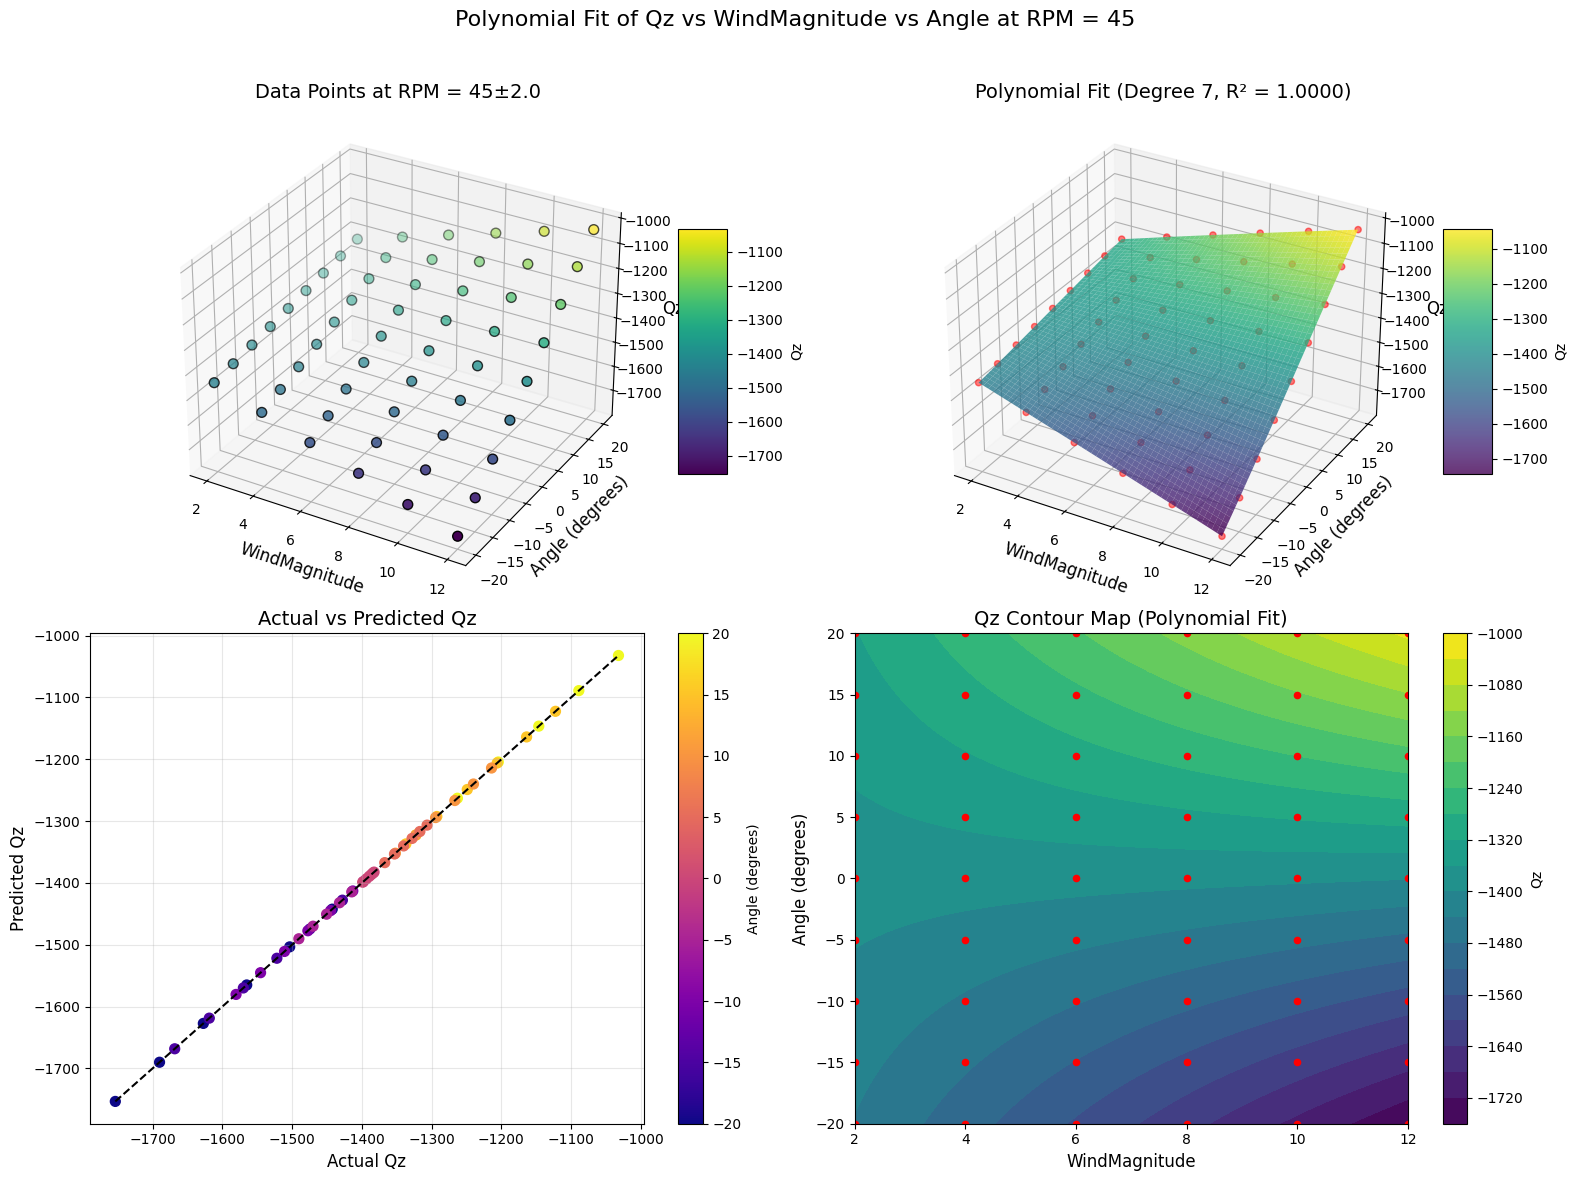


Polynomial Equation for Qz at RPM = 45:
Qz = -1387.849762 + 5.778205*1 - 0.009233*WindMag + 0.662654*Angle - 0.031567*WindMag^2 + 0.721879*WindMag Angle - 0.000002*Angle^2 - 0.049389*WindMag^3 + 0.373663*WindMag^2 Angle + 0.000001*WindMag Angle^2 - 0.000000*Angle^3 + 0.012250*WindMag^4 - 0.084557*WindMag^3 Angle + 0.000109*WindMag^2 Angle^2 - 0.000078*WindMag Angle^3 + 0.000000*Angle^4 - 0.001529*WindMag^5 + 0.010066*WindMag^4 Angle + 0.000000*WindMag^3 Angle^2 + 0.000000*WindMag^2 Angle^3 - 0.000000*WindMag Angle^4 + 0.000094*WindMag^6 - 0.000604*WindMag^5 Angle - 0.000000*WindMag^4 Angle^2 - 0.000000*WindMag^3 Angle^3 - 0.000000*WindMag^2 Angle^4 + 0.000000*WindMag Angle^5 - 0.000002*WindMag^7 + 0.000014*WindMag^6 Angle
Equation saved to 'qz_equation_rpm45_degree7.txt'

Testing inverse function to find WindMagnitude and Angle from Qz:
Qz         WindMagnitude   Angle           WindX          
-------------------------------------------------------
-1753.37   12.0000         -20.00  

In [ ]:
# polynomial_fit_qz_rpm45.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline

print("Creating polynomial fit for Qz vs WindMagnitude vs Angle at RPM = 45...")

# Load the data file
try:
    # Read data file (adjust filename if needed)
    df = pd.read_csv('rpm_wind_simulation_results.csv')
    
    # Use the column names specified
    rpm_col = 'RPM'                    # Column A
    wind_mag_col = 'WindMagnitude'     # Column B
    angle_col = 'AngleDegrees'         # Column C
    qz_col = 'Qz'                      # Column M
    
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

# Set the target RPM value
target_rpm = 45

# Filter data for RPM close to target_rpm
rpm_tolerance = 2.0  # Allow 2 RPM deviation
mask = np.abs(df[rpm_col] - target_rpm) <= rpm_tolerance

# Check if we have enough data points
if np.sum(mask) < 10:
    print(f"Warning: Only {np.sum(mask)} data points found with RPM = {target_rpm}±{rpm_tolerance}.")
    print("Increasing tolerance to find more data points...")
    rpm_tolerance = 5.0
    mask = np.abs(df[rpm_col] - target_rpm) <= rpm_tolerance
    print(f"Found {np.sum(mask)} data points with RPM = {target_rpm}±{rpm_tolerance}.")

# Extract the filtered data
filtered_df = df[mask].copy()
filtered_rpm = filtered_df[rpm_col].values
filtered_wind_mag = filtered_df[wind_mag_col].values
filtered_angle = filtered_df[angle_col].values
filtered_qz = filtered_df[qz_col].values

print(f"Using {len(filtered_df)} data points with RPM = {target_rpm}±{rpm_tolerance}")
print(f"Average RPM of the selected data: {np.mean(filtered_rpm):.2f}")

# Create input features for polynomial fitting
X = np.column_stack((filtered_wind_mag, filtered_angle))
y = filtered_qz

# Try different polynomial degrees to find the best fit
best_r2 = -np.inf
best_degree = 1
best_model = None

max_degree = min(8, int(np.sqrt(len(X))))  # Avoid overfitting
print(f"Testing polynomial degrees from 1 to {max_degree}...")

for degree in range(1, max_degree + 1):
    # Create polynomial model
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True),
        LinearRegression()
    )
    
    # Fit the model
    model.fit(X, y)
    
    # Predict and calculate metrics
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print(f"Degree {degree}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    # Keep track of the best model
    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree
        best_model = model

print(f"\nBest polynomial fit: Degree {best_degree} with R² = {best_r2:.4f}")

# Use the best model for visualizations
model = best_model

# Create a meshgrid for visualization
wind_mag_min, wind_mag_max = min(filtered_wind_mag), max(filtered_wind_mag)
angle_min, angle_max = min(filtered_angle), max(filtered_angle)

grid_size = 50
wind_mag_grid = np.linspace(wind_mag_min, wind_mag_max, grid_size)
angle_grid = np.linspace(angle_min, angle_max, grid_size)
wind_mag_mesh, angle_mesh = np.meshgrid(wind_mag_grid, angle_grid)

# Create input points for prediction
mesh_points = np.column_stack((wind_mag_mesh.flatten(), angle_mesh.flatten()))
qz_pred = model.predict(mesh_points).reshape(wind_mag_mesh.shape)

# Create figure for visualizations
plt.figure(figsize=(16, 12))

# 3D Scatter plot of the data points
ax1 = plt.subplot(221, projection='3d')
scatter = ax1.scatter(filtered_wind_mag, filtered_angle, filtered_qz, 
                     c=filtered_qz, cmap=cm.viridis, s=50, edgecolor='k')
ax1.set_xlabel('WindMagnitude', fontsize=12)
ax1.set_ylabel('Angle (degrees)', fontsize=12)
ax1.set_zlabel('Qz', fontsize=12)
ax1.set_title(f'Data Points at RPM = {target_rpm}±{rpm_tolerance}', fontsize=14)
plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5, label='Qz')

# 3D Surface plot of the polynomial fit
ax2 = plt.subplot(222, projection='3d')
surf = ax2.plot_surface(wind_mag_mesh, angle_mesh, qz_pred, 
                       cmap=cm.viridis, alpha=0.8, edgecolor='none')
ax2.scatter(filtered_wind_mag, filtered_angle, filtered_qz, c='red', s=20, alpha=0.5)
ax2.set_xlabel('WindMagnitude', fontsize=12)
ax2.set_ylabel('Angle (degrees)', fontsize=12)
ax2.set_zlabel('Qz', fontsize=12)
ax2.set_title(f'Polynomial Fit (Degree {best_degree}, R² = {best_r2:.4f})', fontsize=14)
plt.colorbar(surf, ax=ax2, shrink=0.5, aspect=5, label='Qz')

# Actual vs Predicted scatter plot
ax3 = plt.subplot(223)
y_pred_train = model.predict(X)
ax3.scatter(filtered_qz, y_pred_train, c=filtered_angle, cmap=cm.plasma, s=50)
ax3.plot([min(filtered_qz), max(filtered_qz)], [min(filtered_qz), max(filtered_qz)], 'k--')
ax3.set_xlabel('Actual Qz', fontsize=12)
ax3.set_ylabel('Predicted Qz', fontsize=12)
ax3.set_title('Actual vs Predicted Qz', fontsize=14)
plt.colorbar(ax3.collections[0], ax=ax3, label='Angle (degrees)')
ax3.grid(True, alpha=0.3)

# Contour plot
ax4 = plt.subplot(224)
contour = ax4.contourf(wind_mag_mesh, angle_mesh, qz_pred, levels=20, cmap=cm.viridis)
ax4.scatter(filtered_wind_mag, filtered_angle, c='red', s=20)
ax4.set_xlabel('WindMagnitude', fontsize=12)
ax4.set_ylabel('Angle (degrees)', fontsize=12)
ax4.set_title('Qz Contour Map (Polynomial Fit)', fontsize=14)
plt.colorbar(contour, ax=ax4, label='Qz')

# Add an overall title
plt.suptitle(f'Polynomial Fit of Qz vs WindMagnitude vs Angle at RPM = {target_rpm}', 
            fontsize=16, y=0.98)

# Adjust layout and save the plot
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Save the figure
output_filename = f'qz_polynomial_fit_rpm{target_rpm}_degree{best_degree}.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"Plot saved as '{output_filename}'")

# Display the plot if in an interactive environment
plt.show()

# Extract polynomial coefficients
poly_features = model[0]
linear_regression = model[1]
coefficients = linear_regression.coef_
intercept = linear_regression.intercept_

# Get feature names
feature_names = poly_features.get_feature_names_out(['WindMag', 'Angle'])

# Print the polynomial equation
print("\nPolynomial Equation for Qz at RPM = 45:")
equation = f"Qz = {intercept:.6f}"
for name, coef in zip(feature_names, coefficients):
    if abs(coef) > 1e-10:  # Only include significant terms
        sign = '+' if coef >= 0 else '-'
        equation += f" {sign} {abs(coef):.6f}*{name}"

print(equation)

# Save the equation to a file
equation_filename = f'qz_equation_rpm{target_rpm}_degree{best_degree}.txt'
with open(equation_filename, 'w') as f:
    f.write(f"Polynomial Fit (Degree {best_degree}) for Qz vs WindMagnitude vs Angle at RPM = {target_rpm}\n")
    f.write(f"R² = {best_r2:.6f}\n\n")
    f.write(equation)

print(f"Equation saved to '{equation_filename}'")

# Create an inverse function to find WindMagnitude and Angle given Qz
def find_wind_params(qz_value, max_attempts=10):
    """
    Find WindMagnitude and Angle that produce the given Qz value.
    Uses optimization to find the solution.
    """
    from scipy.optimize import minimize
    
    def objective(params):
        wind_mag_val, angle_val = params
        X_test = np.array([[wind_mag_val, angle_val]])
        qz_predicted = model.predict(X_test)[0]
        return (qz_predicted - qz_value)**2
    
    best_result = None
    best_error = float('inf')
    
    # Try multiple starting points
    for i in range(max_attempts):
        # Random starting point within the data range
        start_wind_mag = np.random.uniform(wind_mag_min, wind_mag_max)
        start_angle = np.random.uniform(angle_min, angle_max)
        
        try:
            result = minimize(
                objective, 
                [start_wind_mag, start_angle],
                method='L-BFGS-B',
                bounds=[(wind_mag_min, wind_mag_max), (angle_min, angle_max)]
            )
            
            if result.fun < best_error:
                best_result = result
                best_error = result.fun
        except:
            continue
    
    if best_result is None:
        return None, None, None
    
    wind_mag_optimal, angle_optimal = best_result.x
    wind_x_optimal = wind_mag_optimal * np.cos(np.radians(angle_optimal))
    
    return wind_mag_optimal, angle_optimal, wind_x_optimal

# Test the inverse function with a few Qz values
print("\nTesting inverse function to find WindMagnitude and Angle from Qz:")
test_qz_values = np.linspace(min(filtered_qz), max(filtered_qz), 5)

print("{:<10} {:<15} {:<15} {:<15}".format("Qz", "WindMagnitude", "Angle", "WindX"))
print("-" * 55)

for qz_val in test_qz_values:
    wind_mag, angle, wind_x = find_wind_params(qz_val)
    print("{:<10.2f} {:<15.4f} {:<15.2f} {:<15.4f}".format(qz_val, wind_mag, angle, wind_x))

# Save the model for future use
import pickle
model_filename = f'qz_model_rpm{target_rpm}_degree{best_degree}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)
print(f"\nModel saved to '{model_filename}'")

# Create a simple function for predictions
def predict_qz(wind_magnitude, angle):
    """Predict Qz value for given WindMagnitude and Angle at RPM = 45."""
    X_pred = np.array([[wind_magnitude, angle]])
    return model.predict(X_pred)[0]

# Print a small table of predictions
print("\nSample predictions for different WindMagnitude and Angle values:")
print("{:<15} {:<15} {:<15}".format("WindMagnitude", "Angle (deg)", "Predicted Qz"))
print("-" * 45)

for wind_mag_val in np.linspace(wind_mag_min, wind_mag_max, 5):
    for angle_val in np.linspace(angle_min, angle_max, 3):
        qz_pred_val = predict_qz(wind_mag_val, angle_val)
        print("{:<15.2f} {:<15.2f} {:<15.2f}".format(wind_mag_val, angle_val, qz_pred_val))

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from mpl_toolkits.mplot3d import Axes3D
import os

def analyze_qz_wind_angle_relationship(csv_file='wind_data.csv'):
    """
    Analyze relationship between Qz and wind parameters.
    Reads from CSV file and fits a model to predict angle from Qz.
    
    Parameters:
    - csv_file: Path to CSV file with wind simulation data
    """
    print(f"Analyzing Qz data from {csv_file}...")
    
    # Check if file exists
    if not os.path.exists(csv_file):
        print(f"Error: File {csv_file} not found.")
        return
    
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Print column names to verify structure
        print("CSV columns:", df.columns.tolist())
        
        # Assuming the CSV contains columns for RPM, wind magnitude, wind angle, and Qz
        # Adjust column names to match your actual CSV structure
        rpm_col = 'RPM'
        wind_mag_col = 'WindMagnitude'
        angle_col = 'AngleDegrees'
        qz_col = 'Qz'
        
        # Filter data for RPM ≈ 45
        rpm_target = 45
        rpm_tolerance = 5
        filtered_df = df[(df[rpm_col] >= rpm_target - rpm_tolerance) & 
                         (df[rpm_col] <= rpm_target + rpm_tolerance)]
        
        print(f"Found {len(filtered_df)} data points with RPM ≈ 45.")
        
        if len(filtered_df) < 10:
            print("Warning: Very few data points for analysis.")
            return
        
        # Extract the relevant columns
        magnitude = filtered_df[wind_mag_col].values
        angle = filtered_df[angle_col].values
        qz = filtered_df[qz_col].values
        
        # Create 3D visualization of the data
        fig = plt.figure(figsize=(15, 12))
        plt.suptitle('Analysis of Qz vs Wind Magnitude vs Angle at RPM ≈ 45', fontsize=16)
        
        # 3D scatter plot
        ax1 = fig.add_subplot(221, projection='3d')
        scatter = ax1.scatter(magnitude, angle, qz, c=qz, cmap='viridis', s=50)
        ax1.set_xlabel('Wind Magnitude')
        ax1.set_ylabel('Angle (degrees)')
        ax1.set_zlabel('Qz')
        ax1.set_title('3D Scatter of Data Points')
        fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5, label='Qz')
        
        # Fit models to the data
        # Model 1: Qz = a*Magnitude + b*Magnitude*cos(Angle) + c
        def model1(X, a, b, c):
            mag, ang_rad = X
            return a*mag + b*mag*np.cos(ang_rad) + c
        
        # Model 2: Qz = a*Magnitude + b*Magnitude*cos(Angle) + c*Magnitude*sin(Angle) + d
        def model2(X, a, b, c, d):
            mag, ang_rad = X
            return a*mag + b*mag*np.cos(ang_rad) + c*mag*np.sin(ang_rad) + d
        
        # Prepare data for curve fitting
        X_data = np.vstack((magnitude, np.radians(angle)))
        
        # Fit Model 1
        try:
            params1, _ = curve_fit(model1, X_data, qz)
            a1, b1, c1 = params1
            
            # Calculate predictions and R²
            qz_pred1 = model1(X_data, *params1)
            r2_1 = 1 - np.sum((qz - qz_pred1)**2) / np.sum((qz - np.mean(qz))**2)
            
            print("\nModel 1: Qz = a*Magnitude + b*Magnitude*cos(Angle) + c")
            print(f"a = {a1:.4f}, b = {b1:.4f}, c = {c1:.4f}")
            print(f"R² = {r2_1:.4f}")
            
            # Create a surface plot of the fitted model
            ax2 = fig.add_subplot(222, projection='3d')
            
            # Create a mesh grid for visualization
            mag_range = np.linspace(min(magnitude), max(magnitude), 20)
            ang_range = np.linspace(min(angle), max(angle), 20)
            Mag, Ang = np.meshgrid(mag_range, ang_range)
            
            # Calculate Qz using the model for each point in the grid
            Qz_model = model1((Mag.flatten(), np.radians(Ang.flatten())), *params1)
            Qz_model = Qz_model.reshape(Mag.shape)
            
            # Plot the surface
            surf = ax2.plot_surface(Mag, Ang, Qz_model, cmap='viridis', alpha=0.7)
            ax2.scatter(magnitude, angle, qz, c='red', s=20)
            ax2.set_xlabel('Wind Magnitude')
            ax2.set_ylabel('Angle (degrees)')
            ax2.set_zlabel('Qz')
            ax2.set_title(f'Model 1 Fit (R² = {r2_1:.4f})')
            
            # Create a function to find angle from Qz and magnitude
            def find_angle_from_qz_model1(qz_value, magnitude_value):
                """Find possible angles from Qz using Model 1."""
                # Calculate cosine value
                cos_val = (qz_value - a1*magnitude_value - c1) / (b1*magnitude_value)
                
                # Check if value is within valid cosine range
                if cos_val < -1 or cos_val > 1:
                    return None
                
                # Get the angle magnitude
                angle_magnitude = np.degrees(np.arccos(cos_val))
                
                # Return both possible angles (positive and negative)
                return [angle_magnitude, -angle_magnitude]
            
            # Demonstrate angle prediction from Qz
            ax3 = fig.add_subplot(223)
            
            # For each unique magnitude, plot Qz vs Angle
            unique_magnitudes = sorted(list(set(magnitude)))
            for mag in unique_magnitudes:
                # Filter data for this magnitude
                mag_df = filtered_df[filtered_df[wind_mag_col] == mag]
                
                if len(mag_df) > 0:
                    # Sort by angle
                    mag_df = mag_df.sort_values(by=angle_col)
                    
                    # Plot actual data
                    ax3.scatter(mag_df[angle_col], mag_df[qz_col], 
                               label=f'Mag={mag}' if mag == unique_magnitudes[0] else "", alpha=0.7)
                    
                    # Plot model prediction
                    angles = np.linspace(min(angle), max(angle), 100)
                    qz_predicted = model1((np.full_like(angles, mag), np.radians(angles)), *params1)
                    ax3.plot(angles, qz_predicted, '--', 
                            label=f'Model (Mag={mag})' if mag == unique_magnitudes[0] else "")
            
            ax3.set_xlabel('Angle (degrees)')
            ax3.set_ylabel('Qz')
            ax3.set_title('Qz vs Angle by Magnitude')
            ax3.grid(True)
            if len(unique_magnitudes) < 7:  # Only show legend if not too cluttered
                ax3.legend()
            
            # Test accuracy of angle prediction
            ax4 = fig.add_subplot(224)
            
            # Predict angles from Qz and plot against actual angles
            predicted_angles = []
            actual_angles = []
            used_magnitudes = []
            
            for i in range(len(qz)):
                predicted = find_angle_from_qz_model1(qz[i], magnitude[i])
                if predicted is not None:
                    # Find which predicted angle is closer to actual
                    actual = angle[i]
                    if abs(predicted[0] - abs(actual)) < abs(predicted[1] - abs(actual)):
                        predicted_angle = predicted[0] * np.sign(actual)
                    else:
                        predicted_angle = predicted[1] * np.sign(actual)
                    
                    predicted_angles.append(predicted_angle)
                    actual_angles.append(actual)
                    used_magnitudes.append(magnitude[i])
            
            # Plot predicted vs actual angles
            scatter = ax4.scatter(actual_angles, predicted_angles, c=used_magnitudes, 
                                 cmap='viridis', alpha=0.7)
            ax4.plot([-90, 90], [-90, 90], 'r--')  # Diagonal line for perfect prediction
            ax4.set_xlabel('Actual Angle (degrees)')
            ax4.set_ylabel('Predicted Angle (degrees)')
            ax4.set_title('Angle Prediction Accuracy')
            ax4.grid(True)
            plt.colorbar(scatter, ax=ax4, label='Wind Magnitude')
            
            # Calculate angle prediction error
            prediction_errors = np.abs(np.array(predicted_angles) - np.array(actual_angles))
            mean_abs_error = np.mean(prediction_errors)
            print(f"\nAngle Prediction Mean Absolute Error: {mean_abs_error:.2f} degrees")
            
            # Display instructions for using the model
            print("\nTo find wind angle from Qz at RPM ≈ 45:")
            print(f"1. Use the equation: cos(Angle) = (Qz - {a1:.4f}*Magnitude - {c1:.4f}) / ({b1:.4f}*Magnitude)")
            print("2. Angle = ±arccos(result from step 1)")
            print("3. Determine sign based on one of the methods discussed (IMU, RPM variation, etc.)")
            
            # Function to estimate wind angle from Qz
            def estimate_wind_angle(qz_value, magnitude_value=None):
                """
                Estimate wind angle from Qz value. If magnitude is unknown,
                tries to estimate it as well.
                """
                if magnitude_value is not None:
                    # If magnitude is known, directly calculate angle
                    angles = find_angle_from_qz_model1(qz_value, magnitude_value)
                    if angles is None:
                        return "No valid solution found for this Qz and magnitude."
                    return f"Possible angles: {angles[0]:.2f}° or {angles[1]:.2f}°"
                else:
                    # If magnitude is unknown, try different values and find solutions
                    possible_solutions = []
                    for test_mag in np.linspace(min(magnitude), max(magnitude), 10):
                        angles = find_angle_from_qz_model1(qz_value, test_mag)
                        if angles is not None:
                            possible_solutions.append((test_mag, angles))
                    
                    if not possible_solutions:
                        return "No valid solutions found."
                    
                    result = "Possible solutions (Magnitude, Angles):\n"
                    for mag, angles in possible_solutions:
                        result += f"  Mag={mag:.2f}: {angles[0]:.2f}° or {angles[1]:.2f}°\n"
                    return result
            
            # Example usage
            print("\nExample Usage:")
            example_qz = np.median(qz)
            example_mag = np.median(magnitude)
            print(f"For Qz = {example_qz:.2f} and Magnitude = {example_mag:.2f}:")
            print(estimate_wind_angle(example_qz, example_mag))
            
            print(f"\nFor Qz = {example_qz:.2f} with unknown magnitude:")
            print(estimate_wind_angle(example_qz))
            
        except Exception as e:
            print(f"Error fitting Model 1: {e}")
        
        # Try fitting Model 2 as well
        try:
            params2, _ = curve_fit(model2, X_data, qz)
            a2, b2, c2, d2 = params2
            
            # Calculate predictions and R²
            qz_pred2 = model2(X_data, *params2)
            r2_2 = 1 - np.sum((qz - qz_pred2)**2) / np.sum((qz - np.mean(qz))**2)
            
            print("\nModel 2: Qz = a*Magnitude + b*Magnitude*cos(Angle) + c*Magnitude*sin(Angle) + d")
            print(f"a = {a2:.4f}, b = {b2:.4f}, c = {c2:.4f}, d = {d2:.4f}")
            print(f"R² = {r2_2:.4f}")
            
            # If Model 2 is significantly better, might want to use it instead
            if r2_2 > r2_1 + 0.05:  # At least 5% improvement
                print("Model 2 provides a significantly better fit and could be used for more accurate predictions.")
        except Exception as e:
            print(f"Error fitting Model 2: {e}")
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig('qz_wind_angle_analysis.png', dpi=300, bbox_inches='tight')
        print(f"\nAnalysis plot saved as 'qz_wind_angle_analysis.png'")
        
    except Exception as e:
        print(f"Error analyzing data: {e}")

# Call the function with your CSV file path
if __name__ == "__main__":
    import sys
    
    if len(sys.argv) > 1:
        csv_file = sys.argv[1]
    else:
        csv_file = 'rpm_wind_simulation_results.csv'  # Default name
    
    analyze_qz_wind_angle_relationship(csv_file)

Analyzing Qz data from --f=c:\Users\Aero\AppData\Roaming\jupyter\runtime\kernel-v3038fc3b1e25a8a6fe1f1674a606c96ea14351e0f.json...
Error: File --f=c:\Users\Aero\AppData\Roaming\jupyter\runtime\kernel-v3038fc3b1e25a8a6fe1f1674a606c96ea14351e0f.json not found.
